This code and data was provided by Krishnaswamy Lab. We use the exact same code to preprocess the data to ensure comparability of results.

# Introduction

In this tutorial, we demonstrate how to use PHATE (Potential of Heat-diffusion for Affinity-based Transition Embedding) to analyze a 31,000 cell 27-day time course of embryoid body (EB) differentiation. You can run and edit this notebook at https://colab.research.google.com/github/KrishnaswamyLab/PHATE/blob/master/Python/tutorial/EmbryoidBody.ipynb. Running the tutorial should take approximately 15 minutes excluding the t-SNE comparison, or 2.5 hours including the comparison.

We review the following steps:

[1. Loading 10X data](#loading)  
[2. Preprocessing: Filtering, Normalizing, and Transforming](#preprocessing)  
[3. Embedding Data Using PHATE](#embedding)  


### Time course of human embryoid body differentation

Low passage H1 hESCs were maintained on Matrigel-coated dishes in DMEM/F12-N2B27 media supplemented with FGF2. For EB formation, cells were treated with Dispase, dissociated into small clumps and plated in non-adherent plates in media supplemented with 20% FBS,
45
which was prescreened for EB differentiation. Samples were collected during 3-day intervals during a 27 day-long differentiation timecourse. An undifferentiated hESC sample was also included (Figure S7D). Induction of key germ layer markers in these EB cultures was validated by qPCR (data not shown). For single cell analyses, EB cultures were dissociated, FACS sorted to remove doublets and dead cells and processed on a 10x genomics instrument to generate cDNA libraries, which were then sequenced. Small scale sequencing determined that we have successfully collected data on approximately 31,000 cells equally distributed throughout the timecourse.


In [1]:
import sys
import os
#limit the number of threds numpy/scipy are using
os.environ["OMP_NUM_THREADS"] = "10"
import time 
import pickle
import pandas as pd
import numpy as np
import multiprocessing as mp
import phate
import scprep
import scipy.sparse

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib as mpl
mpl.rcParams['figure.titlesize'] = 24
mpl.rcParams['axes.titlesize']   = 24
mpl.rcParams['axes.labelsize']   = 24
mpl.rcParams['xtick.labelsize']  = 24
mpl.rcParams['ytick.labelsize']  = 24

%load_ext autoreload
%autoreload 2

# matplotlib settings for Jupyter notebooks only
%matplotlib inline


<a id='loading'></a>
## 1. Loading 10X data

### Downloading Data from Mendeley Datasets

The EB dataset is publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. 

Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Here's the directory structure:
```
download_path
└── scRNAseq
    ├── scRNAseq.zip
    ├── T0_1A
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T2_3B
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T4_5C
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T6_7D
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    └── T8_9E
        ├── barcodes.tsv
        ├── genes.tsv
        └── matrix.mtx
```

If you have downloaded the files already, set the `download_path` below to the directory where you saved the files. If not, the following code will download the data for you. Not that the download is 746MB: you must have sufficient disk space for the download.

In [3]:
import os
import zipfile
from urllib.request import urlopen
download_path = os.path.expanduser(".")
print(download_path)

.


In [6]:
import os
import zipfile
if not os.path.isdir(os.path.join(download_path, "scRNAseq", "T0_1A")):
    if not os.path.isdir(download_path):
        os.mkdir(download_path)
    zip_data = os.path.join(download_path, "scRNAseq.zip")
    if not os.path.isfile(zip_data):
        with urlopen("https://data.mendeley.com/datasets/v6n743h5ng"
                     "/1/files/7489a88f-9ef6-4dff-a8f8-1381d046afe3/scRNAseq.zip?dl=1") as url:
            print("Downloading data file...")
            # Open our local file for writing
            with open(zip_data, "wb") as handle:
                handle.write(url.read())
    print("Unzipping...")
    with zipfile.ZipFile(zip_data, 'r') as handle:
        handle.extractall(download_path)
    print("Done.")

Unzipping...
Done.


### Using `scprep` to import data into Pandas DataFrames


We use a toolkit for loading and manipulating single-cell data called `scprep`. The function `load_10X` will automatically load 10X scRNAseq datasets (and others) into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).


Let's load the data and create a single matrix that we can use for preprocessing, visualization, and analysis.

#### 0. Install PHATE

If you have not already installed PHATE and `scprep`, we can install them from the notebook. You may need to restart the kernel/runtime after installation.

In [5]:
!pip install --user phate scprep

    100% |████████████████████████████████| 61kB 7.8MB/s 
    100% |████████████████████████████████| 1.8MB 11.6MB/s 


#### 1. Standard imports

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import time

import pandas as pd
import numpy as np
import phate
import scprep
import scipy.sparse

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

#### 2. Use `scprep.io.load_10X` to import all three matrices into a DataFrame for each sample (this may take a few minutes)

Note: By default, `scprep.io.load_10X` loads scRNA-seq data using the Pandas SparseDataFrame [(**see Pandas docs**)](https://pandas.pydata.org/pandas-docs/stable/sparse.html) to maximize memory efficiency. However, this will be slower than loading on a dense matrix. To load a dense matrix, pass the `sparse=False` argument to `load_10X`. We use `gene_labels = 'both'` so we can see the gene symbols while still retaining the uniqueness offered by gene IDs.

In [7]:
sparse=True
download_path = os.path.expanduser(".")
print(download_path)
T1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
T2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
T3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
T4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
T5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
T1.head()

.


,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,
AAACATACCAGAGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAAGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAAGTGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGAGGTG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGGTTTCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


** 3. Library size filtering **

We filter out cells that have either very large or very small library sizes. For this data set, library size correlates somewhat with sample and so we filter on a per-sample basis. In this case, we eliminate the top and bottom 20% of cells for each sample. Similar results are obtained with simpler, less conservative filtering.

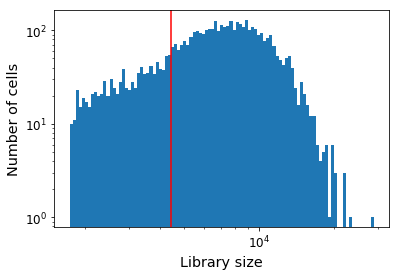

In [8]:
scprep.plot.plot_library_size(T1, percentile=20)

In [9]:
filtered_batches = []
for batch in [T1, T2, T3, T4, T5]:
    batch = scprep.filter.filter_library_size(batch, percentile=20, keep_cells='above')
    batch = scprep.filter.filter_library_size(batch, percentile=75, keep_cells='below')
    filtered_batches.append(batch)
del T1, T2, T3, T4, T5 # removes objects from memory

#### 4. Merge all datasets and create a vector representing the time point of each sample

In [10]:
EBT_counts, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"],
    append_to_cell_names=True
)
del filtered_batches # removes objects from memory
EBT_counts.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),...,AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
AAACATTGAAAGCA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCAGAAA-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGAAGGC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCGGTAT-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACCTATTC-1_Day 00-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id='preprocessing'></a>
## 2. Preprocessing: Filtering, Normalizing, and Transforming

### Filtering

We filter the data by: 
1. Removing dead cells  
2. Filtering by library size (if we did not do this prior to combining batches)
3. Removing genes that are expressed in relatively few cells.

#### 2.1 Dead cell removal

Dead cells are likely to have a higher mitochondrial RNA expression level than live cells. Therefore, we remove suspected dead cells by eliminating cells that have the highest mitochondrial RNA expression levels on average.  

First let's look at the distribution of mitochontrial genes.

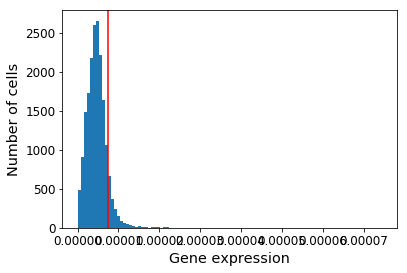

In [11]:
mito_genes = scprep.utils.get_gene_set(EBT_counts, starts_with="MT-") # Get all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(EBT_counts, genes=mito_genes, percentile=90)

Here we see that above the top 90th percentile, there is a steep increase in expression of mitochondrial RNAs. We'll remove these cells from further analysis.

In [12]:
EBT_counts, sample_labels = scprep.filter.filter_gene_set_expression(
    EBT_counts, sample_labels, genes=mito_genes, 
    percentile=90, 
    keep_cells='below')

** 2.2: Library size filtering **

We did this before, because the library size correlated strongly with our samples. However, if we wanted to do something simplier, we could have run the following here instead:

`EBT_counts, sample_labels = scprep.filter.library_size_filter(EBT_counts, sample_labels, cutoff=2000)`

#### 2.3 Remove rare genes

We eliminate genes that are expressed in 10 cells or fewer.

In [13]:
EBT_counts = scprep.filter.filter_rare_genes(EBT_counts, min_cells=10)

### Normalization

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the median library size.

In python this is performed using the preprocessing method `library_size_normalize()`.

In [14]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)
type(EBT_counts.values)

### Transformation

In scRNA-seq analysis, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [16]:
EBT_sqrt = scprep.transform.sqrt(EBT_counts)
EBT_sqrt.to_pickle("EBT_sqrt.pkl")
np.save('EBT_sample_labels.npy', sample_labels)

<a id='embedding'></a>
## 3. Embedding Data Using PHATE

### 3.1 Instantiating the PHATE estimator

The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `knn` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `k` if your dataset is extremely large (e.g. >100k cells)
* `decay` : Alpha decay (default: 15). Decreasing `a` increases connectivity on the graph, increasing `a` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

Here's the simplest way to apply PHATE:

In [9]:
start = time.time()
phate_operator = phate.PHATE(n_jobs=10)
Y_phate = phate_operator.fit_transform(EBT_sqrt)
end = time.time()
print("Embedded PHATE in {:.2f} seconds.".format(end-start))

Calculating PHATE...
  Running PHATE on 16821 cells and 17619 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 44.46 seconds.
    Calculating KNN search...
    Calculated KNN search in 29.83 seconds.
    Calculating affinities...
    Calculated affinities in 0.51 seconds.
  Calculated graph and diffusion operator in 90.67 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.65 seconds.
    Calculating KMeans...
    Calculated KMeans in 29.67 seconds.
  Calculated landmark operator in 34.75 seconds.
  Calculating optimal t...
    Automatically selected t = 21
  Calculated optimal t in 1.73 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.65 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 23.98 seconds.
Calculated PHATE in 151.79 seconds.
Embedded PHATE in 151.79 seconds.


And then we plot using `scprep.plot.scatter2d`. For more advanced plotting, we recommend Matplotlib. If you want more help on using Matplotlib, they have [**extensive documentation**](https://matplotlib.org/tutorials/index.html) and [**many Stackoverflow threads**](https://stackoverflow.com/questions/tagged/matplotlib).

In [7]:
Y_phate.shape

(16821, 2)

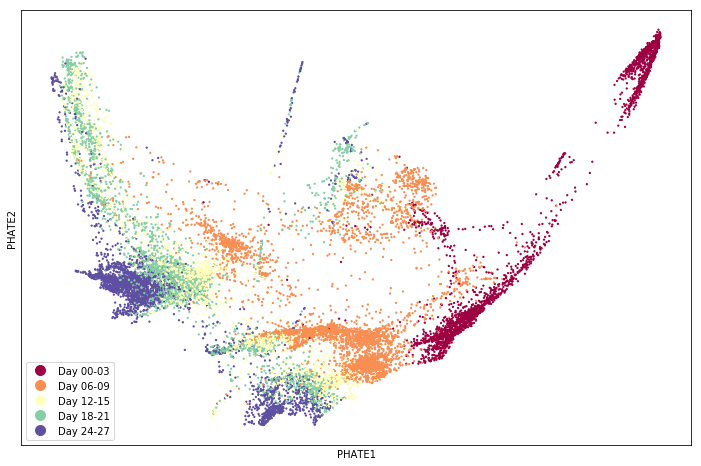

In [8]:
scprep.plot.scatter2d(Y_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

Since we are looking for subtle structure and we expect some of the trajectories to be sparse, we might want to decrease `k` from the default of 5, and reduce `t` from the automatic value of 21 (printed in the output above). For single-cell RNA-seq you can try `k` as low as 3 or 4 if you're looking for subtle structure, or as high as 30 or 40 if you have hundreds of thousands of cells. We'll also reduce `a` here to 15 to partially offset the decreased connectivity as a result of decreasing `k`.

In [ ]:
# phate_operator.set_params(knn=4, decay=15, t=12)
# # We could also create a new operator:
# # phate_operator = phate.PHATE(knn=4, decay=15, t=12, n_jobs=-2)

# Y_phate = phate_operator.fit_transform(EBT_sqrt)
# scprep.plot.scatter2d(Y_phate, c=sample_labels, figsize=(12,8), cmap="Spectral",
#                       ticks=False, label_prefix="PHATE")